<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_branch/ML2021HW1_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Pytorch Setting:

In [1]:
#import pytorch
import torch

# torch.backends.cudnn: set CNN algorithmtorch.backends.cudnn
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# get the current available device ('cpu' or 'cuda')
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(torch.cuda.is_available())
#set random variable
import numpy as np
myseed = 1
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

True


##Data Set

In [2]:
#write data_set_function
#normalize data if needed
import pandas as pd
def normalize(df):
    return ((df - df.mean(axis = 0)) / (df.std(axis = 0)))
# generate index_list for spliting train & validation set
def got_index(df,mode):
    index_list = []
    first_day = 0
    for i in range(df.shape[1]):
      #count total data in that catetory
      days = df.iloc[:,i].sum()

      last_day = int(first_day + days-1)
      split_day = int(first_day + days*0.9)

      if mode == "train":
        index_list += list(range(first_day,split_day+1))
      elif mode == "val":
        index_list += list(range(split_day+1,last_day+1))

      first_day = last_day+1
    return index_list

#split train & validation set by index
def covid19_train_val_f(mode,d_l = "both"):
    train__val_df = pd.read_csv(data_info[mode]["path"])
    print('Size of training data: {}'.format(train__val_df.shape))

    train__val_df.iloc[:,41:-1] = normalize(train__val_df.iloc[:,41:-1])

    index_list = got_index(train__val_df.iloc[:,1:41],mode)
    train__val_df = train__val_df.iloc[ index_list,1:]
    label = torch.FloatTensor(train__val_df.iloc[:, -1].to_numpy())
    label = torch.unsqueeze(label, 1)
    data = torch.FloatTensor(train__val_df.iloc[:, 0:-1].to_numpy())
    return({"data":data , "label":label})

def covid19_test_f(mode,d_l = "data"):
    test_df = pd.read_csv(data_info[mode]["path"])
    print('Size of testing data: {}'.format(test_df.shape))
    test_df.iloc[:,41:] = normalize(test_df.iloc[:,41:])
    data = torch.FloatTensor(test_df.to_numpy()[:,1:])
    return(data)
#create a dict of functions and path w.r.t. different mode
data_info = {
    "train":{"function":covid19_train_val_f,"path":"./covid.train.csv","data_or_label":"both"},
    "val":{"function":covid19_train_val_f,"path":"./covid.train.csv","data_or_label":"both"},
    "test":{"function":covid19_test_f,"path":"./covid.test.csv","data_or_label":"data"}
}

In [3]:
#rewrite class Dataset
from torch.utils.data import Dataset, DataLoader
class Dataset_preparation(Dataset):
  def __init__(self,mode,data_info):
      self.mode = mode
      self.data_or_label = data_info[mode]["data_or_label"]

      if self.data_or_label == "data":
        self.data = data_info[self.mode]["function"](self.mode,"data")
      elif self.data_or_label == "both":
        self.data = data_info[self.mode]["function"](self.mode,"both")["data"]
        self.label = data_info[self.mode]["function"](self.mode,"both")["label"]
      else :
        self.label = data_info[self.mode]["function"](self.mode,"label")["label"]

      self.dim = self.data.shape[1]
      print('Finished reading the {mode} set of Dataset ({len} samples found, each dim = {dim})'
              .format(mode = self.mode, len =len(self.data), dim=self.dim))

  def __getitem__(self, index):
      if self.data_or_label == "data":
        return self.data[index]
      elif self.data_or_label == "both":
        return self.data[index], self.label[index]
      else :
        return self.label[index]
  def __len__(self):
      # Returns the size of the dataset
      return len(self.data)

In [4]:
#test_test = Dataset_preparation("test",data_info)
print(covid19_train_val_f("val",d_l = "both")["label"].size())

Size of training data: (2700, 95)
torch.Size([240, 1])


In [5]:
#decide how to load data
def prep_dataloader(mode,d_info,batch_size,n_jobs=0):
    dataset = Dataset_preparation(mode,d_info)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=False)
    return dataloader

In [6]:
from torch.nn.modules.activation import Sigmoid
import torch.nn as nn
class Multi100Layer(nn.Module):
    def __init__(self):
        super(Multi100Layer, self).__init__()
    def forward(self, x):
        x = 100.0 * x
        return x
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
#            nn.Sigmoid(),
#            Multi100Layer()
            )

        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        x = self.net(x)
        return x

    def cal_loss(self, pred, target):

        return self.criterion(pred, target)

In [7]:
# x = torch.tensor([5.0])
# model = NeuralNet(1)
# model_d = model.to(device)
# print(model_d(x))

In [8]:
h_paras = {
    # maximum number of epochs
    'n_epochs': 3000,
    # mini-batch size for dataloader
    'batch_size': 270,
    # optimization algorithm (optimizer in torch.optim)
    'optimizer': 'SGD',
    # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'optim_hparas': {
        # learning rate of SGD
        'lr': 0.001,
        # momentum for SGD
        'momentum': 0.9
    },
    # early stopping epochs (the number epochs since your model's last improvement)
    'early_stop': 300,
    # if loss small than this , early-stopping counter will reset(may update in validation process)
    'early_stop_loss_init': 10.0,
    # your model will be saved here
    'save_path': './model.pth'
}

In [9]:
def train(train_set,model_d,optimizer,device):
    # set model to training mode
    model_d.train()
    # iterate through the dataloader
    for data , label in train_set:
      # move data to device (cpu/cuda)
      data_d , label_d = data.to(device), label.to(device)
      # forward pass (compute output tensor)
      pred = (model_d(data_d))
      # compute loss
      mse_loss = model_d.cal_loss(pred , label_d)
      # compute gradient (backpropagation)
      mse_loss.backward()
      # update model with optimizer
      optimizer.step()
      # set optimizer gradient to zero
      optimizer.zero_grad()
      return mse_loss.detach().cpu().item()

In [10]:
def val(val_set,model_d,device):
    # set model to evalutation mode
    model_d.eval()

    total_loss = 0
    # iterate through the dataloader
    for data , label in val_set:
    # move data to device (cpu/cuda)
      data_d, label_d = data.to(device), label.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # compute loss
        mse_loss = model_d.cal_loss(pred, label_d)
      # accumulate loss
      batch_size = len(data_d)
      total_loss += mse_loss.detach().cpu().item() * batch_size
    # compute averaged loss
    totol_size = len(val_set.dataset)
    avg_loss =  total_loss/totol_size
    return avg_loss

In [17]:
def test(test_set, model_d, device):
    # set model to evalutation mode
    model_d.eval()
    preds = []
    # iterate through the dataloader
    for data in test_set:
      # move data to device (cpu/cuda)
      data_d = data.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # collect prediction
        preds+=(pred.detach().tolist())
    # concatenate all predictions and convert to a numpy array
    preds = np.array(preds)
    return preds

In [12]:
def train_val_process(training_set, validation_set, model, h_paras, device):
    #1: move model to device (cpu/cuda)
    model_d = model.to(device)
    #2: set optimizer = torch.optim.SGD(model_d.parameters(),lr=0.001,momentum=0.9)
    optimizer = getattr(torch.optim, h_paras['optimizer'])(
        model_d.parameters(), **h_paras['optim_hparas'])

    #3: set epoch = h_paras['n_epochs'] = 3000
    n_epochs = h_paras['n_epochs']

    #4: record training loss
    loss_record = {'train': [], "val": []}

    #5: setting paras
    # epoch para
    epoch = 0
    # early-stoping paras
    early_stop_cnt = 0
    min_loss = h_paras["early_stop_loss_init"]

    #start training
    while epoch < n_epochs:

      # Part1 : training process
      # updata model weight and compute model loss
      train_loss = train(training_set,model_d,optimizer,device)
      # save loss to loss_record['train']
      loss_record['train'].append(train_loss)
      # renew epoch para
      epoch += 1

      # Part2 validation process
      # After each epoch, test your model
      # on the validation (development) set.
      val_loss = val(validation_set, model_d, device)
      # save loss to loss_record["val"]
      loss_record["val"].append(val_loss)

      # Part3 early stopping
      # Compute early-stopping counter
      if val_loss < min_loss:
        min_loss = val_loss
        print('Saving model (epoch = {:4d}, train_loss = {:.4f}) , val_loss = {:.4f})'\
        .format(epoch , train_loss , val_loss))
      # Save model to specified path if your model improved
        torch.save(model_d.state_dict(), h_paras['save_path'])
        early_stop_cnt = 0
      else:
        early_stop_cnt += 1
      # Check early stop criteria
      if early_stop_cnt > h_paras['early_stop']:
          # Stop training if your model stops improving
          # for "h_paras['early_stop']" epochs.
          break

    print('Finished training after {} epochs'.format(epoch))
    return min_loss, loss_record

In [13]:
train_set = prep_dataloader('train',data_info,h_paras['batch_size'])
val_set = prep_dataloader('val',data_info,h_paras['batch_size'])
test_set = prep_dataloader('test',data_info,h_paras['batch_size'])

Size of training data: (2700, 95)
Size of training data: (2700, 95)
Finished reading the train set of Dataset (2460 samples found, each dim = 93)
Size of training data: (2700, 95)
Size of training data: (2700, 95)
Finished reading the val set of Dataset (240 samples found, each dim = 93)
Size of testing data: (893, 94)
Finished reading the test set of Dataset (893 samples found, each dim = 93)


In [14]:
# model = NeuralNet(train_set.dataset.dim)
# model_d = model.to(device)
# optimizer = torch.optim.SGD(model_d.parameters(),lr = 0.001,momentum=0.9)
# print(optimizer)

In [23]:
# Construct model
model = NeuralNet(train_set.dataset.dim)
model_loss, model_loss_record = train_val_process(train_set, val_set, model, h_paras, device)
#print(model_loss_record["train"])

Saving model (epoch =   35, train_loss = 10.9551) , val_loss = 8.8421)
Saving model (epoch =   39, train_loss = 16.0926) , val_loss = 8.7391)
Saving model (epoch =   46, train_loss = 7.6816) , val_loss = 7.5279)
Saving model (epoch =   49, train_loss = 7.8272) , val_loss = 6.5619)
Saving model (epoch =   50, train_loss = 6.6295) , val_loss = 5.7825)
Saving model (epoch =   57, train_loss = 4.4633) , val_loss = 4.5379)
Saving model (epoch =   58, train_loss = 4.4296) , val_loss = 3.9206)
Saving model (epoch =   59, train_loss = 4.0540) , val_loss = 3.7931)
Saving model (epoch =   68, train_loss = 2.8480) , val_loss = 3.6605)
Saving model (epoch =   69, train_loss = 2.2246) , val_loss = 3.1972)
Saving model (epoch =   70, train_loss = 2.9564) , val_loss = 3.0599)
Saving model (epoch =   71, train_loss = 3.1698) , val_loss = 2.9311)
Saving model (epoch =   72, train_loss = 2.9937) , val_loss = 2.8937)
Saving model (epoch =   78, train_loss = 2.2177) , val_loss = 2.7813)
Saving model (epoc

In [24]:
def save_pred(preds, file_path):
    import pandas as pd
    print('Saving results to {}'.format(file_path))
    df = pd.DataFrame(preds,columns=["tested_positive"])
    df.to_csv(file_path)

In [25]:
preds = test(test_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


In [26]:
del model
model = NeuralNet(train_set.dataset.dim).to(device)  # Construct model and move to device
model_loading = torch.load(h_paras['save_path'], map_location=device)  # Load your best model
model.load_state_dict(model_loading)

<All keys matched successfully>

In [27]:
import matplotlib.pyplot as plt
def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(val_set, model, device, lim=50., preds=None, targets=None):
    if preds is None or targets is None:
        model.eval()
        preds, labels = [], []
        for data , label in val_set:
            data_d , label_d = data.to(device), label.to(device)
            with torch.no_grad():
                pred = model(data_d)
                preds += pred.detach().tolist()
                labels += label_d.detach().tolist()
        preds = np.array(preds)
        labels = np.array(labels)
    plt.figure(figsize=(5, 5))
    plt.scatter(labels, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

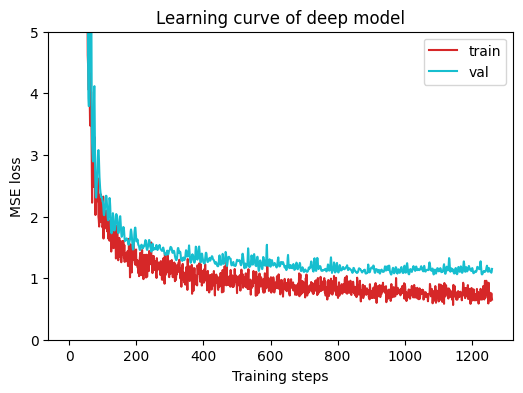

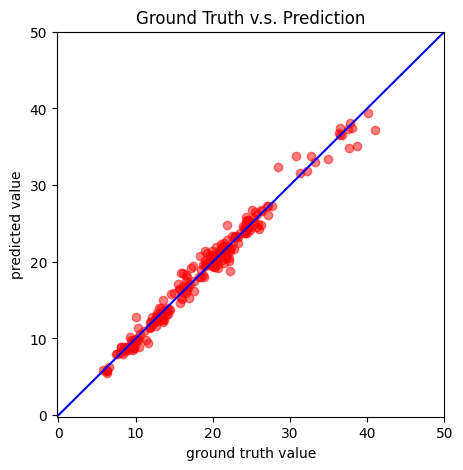

In [28]:
plot_learning_curve(model_loss_record, title='deep model')
plot_pred(val_set, model, device)  # Show prediction on the validation set